# Flash ID validation 
Jupyter notebook to look at a PMT based neutrino ID for the 

## Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import LogNorm
from operator import itemgetter
import helpfunction as helper

In [3]:
%autoreload

## Constants

In [4]:
gr = 1.618
outdir= './output/'
inputdir = './input/'  

mc_start = 3.16
bnb_start = 3.19     # mc_start + 2*0.015625 #3.20
ext_start = 3.58     # mc_start + 26*0.015625 #3.58
intime_start = 3.58  # mc_start + 26*0.015625 # 3.58
duration = 1.68

In [5]:
dict_names = ['nue','nu','on','off','on_rolling'] 
shift_time = [0,0,0.03,0.42]
lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_arr = [10,10,10,10,10,50] 

## Definitions

In [6]:
# Creates a dict with only a selection of keys from the original dict, given as a list ks
def subdict(d, ks):
    return dict(zip(ks, itemgetter(*ks)(d)))

def inTPC(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False   

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return df[mask]

## Loading inputs

In [7]:
file_dict = {}
first = True
start = time.time()
for sample in dict_names:
    file_name = inputdir+'FlashID_'+sample+'_v11.root'
    file = uproot.open(file_name)['pandoraFlashEventBuilding']
    file_dict[sample] = {}
    for tree_name in file.keys():
        name = tree_name.decode('UTF-8').split(';')[0]
        file_dict[sample][name] = file[tree_name].arrays(file[tree_name].keys())
        if first:
            print('*** ', name, ' ***')
            print(file[tree_name].keys())
            print()
    first = False
    print('Loaded',sample, 'sample:', len(file_dict[sample]['events'][b'event']))

print('Loading took  {0:.2f} seconds.'.format(time.time()-start))

***  metadata  ***
[b'beamWindowStart', b'beamWindowEnd', b'minBeamFlashPE', b'maxDeltaY', b'maxDeltaZ', b'maxDeltaYSigma', b'maxDeltaZSigma', b'minChargeToLightRatio', b'maxChargeToLightRatio', b'chargeToNPhotonsTrack', b'chargeToNPhotonsShower']

***  events  ***
[b'run', b'subRun', b'event', b'nFlashes', b'nFlashesInBeamWindow', b'hasBeamFlash', b'nSlices', b'nSlicesAfterPrecuts', b'foundATargetSlice', b'nuInteractionType', b'nuCCNC', b'nuEnergy', b'leptonEnergy', b'nuInteractionTime', b'nuPdgCode', b'nuVertexX', b'nuVertexY', b'nuVertexZ']

***  flashes  ***
[b'run', b'subRun', b'event', b'time', b'centerY', b'centerZ', b'widthY', b'widthZ', b'totalPE', b'peSpectrum', b'inBeamWindow', b'isBrightestInWindow', b'isBeamFlash']

***  slices  ***
[b'run', b'subRun', b'event', b'hasDeposition', b'totalCharge', b'centerX', b'centerY', b'centerZ', b'minX', b'deltaY', b'deltaZ', b'deltaYSigma', b'deltaZSigma', b'chargeToLightRatio', b'passesPreCuts', b'flashMatchScore', b'flashMatchX', b'to

In [8]:
#np.unique(file_dict['off']['events'][b'run'], return_counts=True)

In [9]:
# Save the PE values of beam flashes in a seperate numpy array:
# For the rolling sample, We only want to compare the PE rates with the 
flashPE = []
sliceHypothesisPE = []
for sample in dict_names: 
    print(sample)
    mask = file_dict[sample]['flashes'][b'isBeamFlash']
    print(sum(mask))
    if(sample=='on_rolling'):
        mask = mask & (file_dict[sample]['flashes'][b'run']<13697)
    temp = file_dict[sample]['flashes'][b'peSpectrum'][mask]
    flashPE.append(temp.flatten().reshape(len(temp),32).T)
    del file_dict[sample]['flashes'][b'peSpectrum']
    
    mask = file_dict[sample]['slices'][b'isConsideredByFlashId']
    if(sample=='on_rolling'):
        mask = mask & (file_dict[sample]['slices'][b'run']<13697)
    temp = file_dict[sample]['slices'][b'peHypothesisSpectrum'][mask]
    sliceHypothesisPE.append(temp.flatten().reshape(sum(temp.counts==32),32).T)
    del file_dict[sample]['slices'][b'peHypothesisSpectrum']

nue
97221
nu
97374
on
130234
off
24348
on_rolling
18088


## Quick checks

In [12]:
# Get the POT from the MC samples
pot_nue = sum(file_dict['nue']['subruns'][b'pot'])
print('Total POT in nue file: {0:.4g}'.format(pot_nue))
pot_nu = sum(file_dict['nu']['subruns'][b'pot'])
print('Total POT in nu file: {0:.4g}'.format(pot_nu))

Total POT in nue file: 4.811e+22
Total POT in nu file: 1.243e+20


In [13]:
if 0: # Only run once if you dont know the number of pot and triggers yet
    # Get the run subrun list from data samples
    samples = ['on','off']
    for sample in samples:
        out_name = outdir + 'run_subrun_' + sample + '.txt'
        sun_subrun = np.array([file_dict[sample]['subruns'][b'run'], file_dict[sample]['subruns'][b'subRun']])
        np.savetxt(out_name, sun_subrun.T, fmt='%d')

triggers_off = 2568431
triggers_on_rolling = 1337193
triggers_on = 9027631
pot_on_rolling = 5.736e+18
pot_on = 4.074e19
title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)

scale_off = triggers_on / triggers_off
scale_nu = pot_on / (pot_nu)
scale_nue = pot_on / (pot_nue)
scale_on = 1
scale_on_rolling = pot_on / pot_on_rolling

#['nue','nu','on','off', 'on_rolling'] 
scales = [scale_nue, scale_nu, scale_on, scale_off, scale_on_rolling]
print(scales)

[0.0008467587492612149, 0.3278093195847576, 1, 3.514842719154223, 7.102510460251046]


In [14]:
sample= 'nue'
data = file_dict[sample]['events'][b'nFlashesInBeamWindow']
print('Events with flash in window: {0:.1f}%'.format(sum(data)/len(data)*100))
data = file_dict[sample]['events'][b'hasBeamFlash']
print('Events with flash in window and 50PE: {0:.1f}%'.format(sum(data)/len(data)*100))
nom = file_dict[sample]['events'][b'nSlicesAfterPrecuts']>0 
denom2 = file_dict[sample]['events'][b'nSlices']>0
print('Events passing the precuts: {0:.1f}%'.format(sum(nom)/sum(denom2)*100))

denom = (file_dict[sample]['slices'][b'completeness'] > 0.8) #& (file_dict['slices'][b'isConsideredByFlashId'])
nom = (file_dict[sample]['slices'][b'isTaggedAsTarget'])

print('Selected slice is most complete slice: {0:.1f}%'.format(sum(nom & denom)/sum(denom)*100))
print('Percentage of events with a complete neutrino slice: {0:.1f}%'.format(sum(denom)/sum(denom2)*100))

Events with flash in window: 97.3%
Events with flash in window and 50PE: 97.2%
Events passing the precuts: 83.4%
Selected slice is most complete slice: 85.0%
Percentage of events with a complete neutrino slice: 62.6%


## Flash plots

In [15]:
# Flash PE and timing plot!
# Check if the flash frame is complete:
print(sum(file_dict[sample]['events'][b'nFlashes']))
print(len(file_dict[sample]['flashes'][b'run']))
# Yes! We can trust flashes

113585
113585


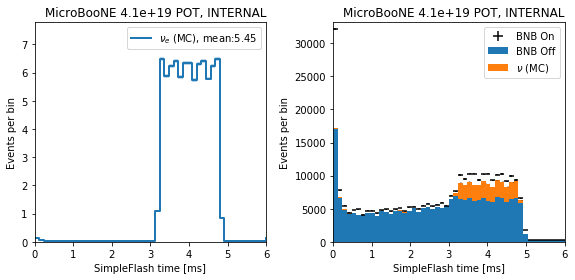

In [16]:
N=50
x_min = 0
x_max = 6
field = b'time'
lab = 'SimpleFlash time [ms]'

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
data = [file_dict[s]['flashes'][field]-dt for s,dt in zip(dict_names, shift_time)]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales)
widths = (edges_mid - edges[:-1])

# Nue MC
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e$ (MC), mean:{0:0.2f}'.format(mean))
ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0,1.2*max_val[0])
ax[0].set_xlabel(lab)
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].legend()

# Data/MC
ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[1].legend()
ax[1].set_xlabel(lab)
ax[1].set_ylabel('Events per bin')
ax[1].set_title(title_str, loc='right')
ax[1].set_ylim(0,1.03*max_val[2])

fig.tight_layout()
fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

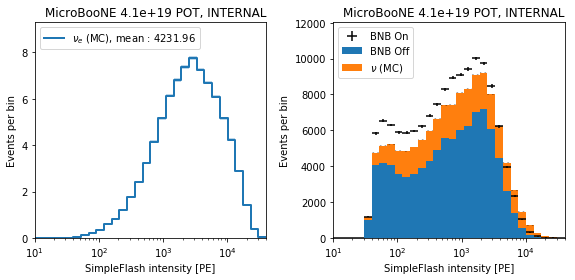

In [17]:
N=30
x_min = 10
x_max = 40000
field = b'totalPE'
lab = 'SimpleFlash intensity [PE]'


fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
mask = [file_dict[s]['flashes'][b'inBeamWindow'] for s in dict_names] 
data = [file_dict[s]['flashes'][field][m]*corr for s, m, corr in zip(dict_names, mask, [1,1,1,1])]
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales, log=True)
widths = (edges_mid - edges[:-1])

# Nue MC
mean = np.mean(data[0][data[0]>-1])
bins[0]=np.append(bins[0],bins[0][0])
err[0]=np.append(err[0],err[0][0])
ax[0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e$ (MC), mean : {0:0.2f}'.format(mean))
ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
ax[0].set_xlim(x_min,x_max)
ax[0].set_ylim(0,1.2*max_val[0])
ax[0].set_xlabel(lab)
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].set_xscale("log", nonposx='clip')
ax[0].legend(loc='upper left')

# Data/MC
ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt="none",label="BNB On")
ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
y_err = np.sqrt(err[1]**2+err[3])
val = bins[3]+bins[1]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

ax[1].legend(loc='upper left')
ax[1].set_xlabel(lab)
ax[1].set_ylabel('Events per bin')
ax[1].set_title(title_str, loc='right')
ax[1].set_xscale("log", nonposx='clip')
ax[1].set_ylim(0,1.2*max_val[2])

fig.tight_layout()
fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

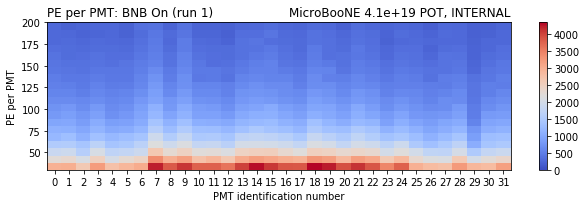

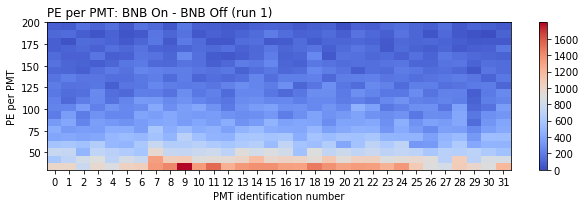

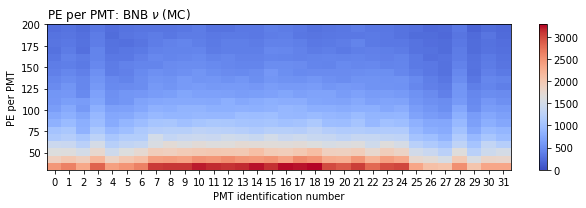

In [18]:
# Make a comparison of the average PE per PMT in the way marco does!

x_data = np.repeat(range(flashPE[3].shape[0]),flashPE[3].shape[1])
y_data = flashPE[3].flatten()
H_off, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))
x_data = np.repeat(range(flashPE[2].shape[0]),flashPE[2].shape[1])
y_data = flashPE[2].flatten()
H_on, _, _ = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))
H = H_on-H_off*scale_off
X, Y = np.meshgrid(xedges, yedges)

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on.T, cmap='coolwarm', vmin=0)
ax.set_xticks(range(32))
fig.colorbar(im)
ax.set_title('PE per PMT: BNB On (run 1)', loc='left')
ax.set_title(title_str, loc='right')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H.T, cmap='coolwarm', vmin=0)
ax.set_xticks(range(32))
ax.set_title('PE per PMT: BNB On - BNB Off (run 1)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

x_data = np.repeat(range(flashPE[1].shape[0]),flashPE[1].shape[1])
y_data = flashPE[1].flatten()
H_mc, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_mc.T, cmap='coolwarm', vmin=0)
ax.set_xticks(range(32))
ax.set_title(r'PE per PMT: BNB $\nu$ (MC)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

BNB on  [43.86087  40.160683 39.44618  38.73979  43.349594 40.342033 55.104214
 72.11697  40.430172 61.51356  35.735607 37.836487 34.948856 45.472572
 53.02772  51.14728  39.76587  38.612904 59.309185 49.618378 40.076283
 52.46862  41.529205 34.28099  42.402626 39.570034 32.165474 50.09711
 37.398815 21.534605 34.32172  42.256733]
BNB off  [44.658268 39.530987 41.51577  39.256477 43.12501  41.906166 57.040726
 74.06686  41.799366 64.93584  36.995037 38.00524  37.81185  47.269814
 54.83743  50.591156 42.1592   40.0893   61.994167 51.510223 41.252556
 52.49418  42.185375 35.347664 42.139103 40.751446 32.426205 51.473667
 38.547512 20.698893 34.46513  39.58877 ]
BNB MC  [59.849903 63.709793 56.48001  73.4779   57.00506  58.765713 62.77402
 68.29663  68.499756 74.92794  76.79723  67.28594  68.7131   67.56627
 67.7777   75.867775 75.42016  67.542534 67.700165 66.79012  65.34538
 77.75483  70.09632  66.568214 64.9695   56.419518 49.406048 45.629646
 66.75117  46.647636 55.22629  52.804897]


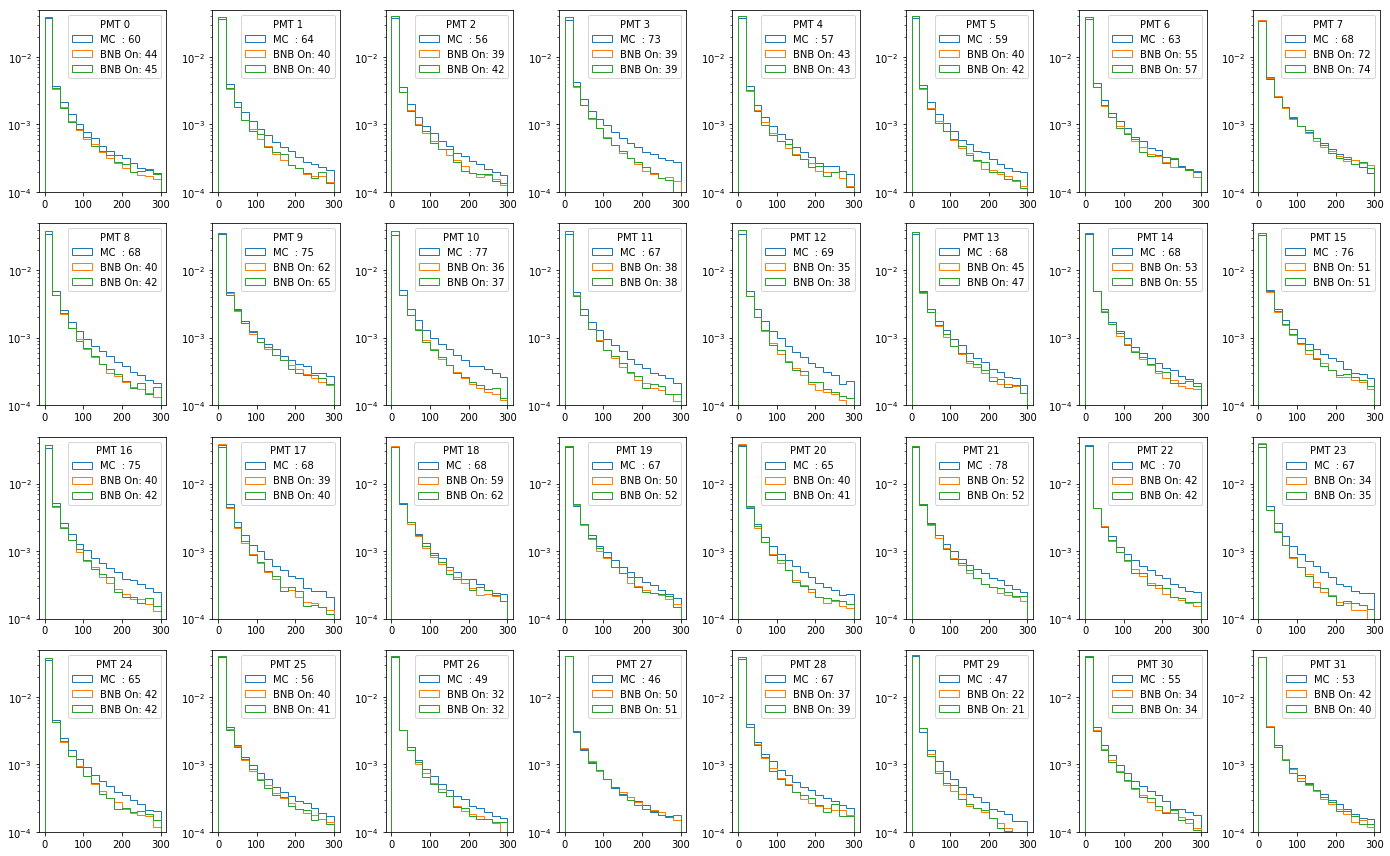

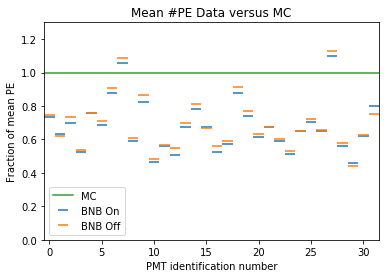

In [21]:
mean_mc = np.mean(flashPE[1],axis=1)
mean_on = np.mean(flashPE[2],axis=1)
mean_off = np.mean(flashPE[3],axis=1)

print("BNB on ", mean_on)
print("BNB off ", mean_off)
print("BNB MC ", mean_mc)

fig,ax = plt.subplots(ncols=8,nrows=4,figsize=(12*gr,12))
ax=ax.flatten()

for i,(pe_on,pe_off, pe_mc) in enumerate(zip(flashPE[2], flashPE[3], flashPE[1])):
    ax[i].hist(pe_mc, density=1, range=(0,300), label='MC  : {0:.0f}'.format(np.mean(pe_mc)), histtype='step', bins=15)
    ax[i].hist(pe_on, density=1, range=(0,300), label='BNB On: {0:.0f}'.format(np.mean(pe_on)), histtype='step', bins=15)
    ax[i].hist(pe_off, density=1, range=(0,300), label='BNB On: {0:.0f}'.format(np.mean(pe_off)), histtype='step', bins=15)
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-4,0.05)
    ax[i].legend(title="PMT "+str(i))
fig.tight_layout()
plt.savefig(outdir+"pe_per_pmt_data_mc.pdf", bbox_inches="tight")
plt.show()

ratio_on  = mean_on/mean_mc
ratio_off = mean_off/mean_mc

plt.errorbar(range(32), ratio_on, xerr= 0.5, fmt='none', label='BNB On')
plt.errorbar(range(32), ratio_off, xerr= 0.5, fmt='none', label='BNB Off')

plt.axhline(1, color='C2', label='MC')
plt.legend(loc = 'lower left')
plt.xlabel('PMT identification number')
plt.ylabel('Fraction of mean PE')
plt.title('Mean #PE Data versus MC')
plt.ylim(0,1.3)
plt.xlim(-0.5,31.5)
plt.savefig(outdir+"pe_per_pmt_data_mc_ratio.pdf", bbox_inches="tight")

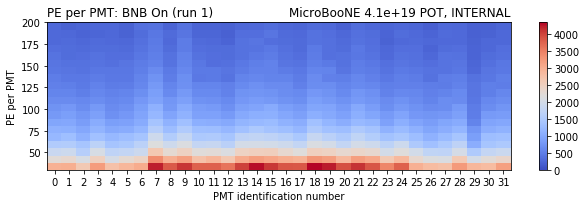

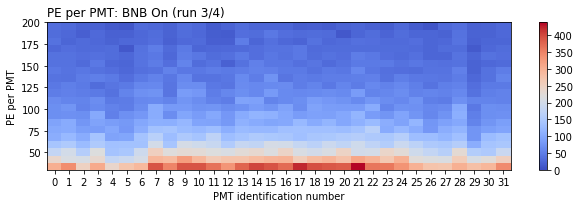

In [20]:
x_data = np.repeat(range(flashPE[4].shape[0]),flashPE[4].shape[1])
y_data = flashPE[4].flatten()
H_on_rolling, xedges, yedges = np.histogram2d(x_data, y_data, bins=(32,20), range=((-0.5,31.5),(30,200)))

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on.T, cmap='coolwarm', vmin=0)
ax.set_xticks(range(32))
fig.colorbar(im)
ax.set_title('PE per PMT: BNB On (run 1)', loc='left')
ax.set_title(title_str, loc='right')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(5.5*gr,3))
im = ax.pcolormesh(X, Y, H_on_rolling.T, cmap='coolwarm', vmin=0)
ax.set_xticks(range(32))
ax.set_title('PE per PMT: BNB On (run 3/4)', loc='left')
ax.set_xlabel('PMT identification number')
ax.set_ylabel('PE per PMT')
fig.colorbar(im)
fig.tight_layout()
plt.show()

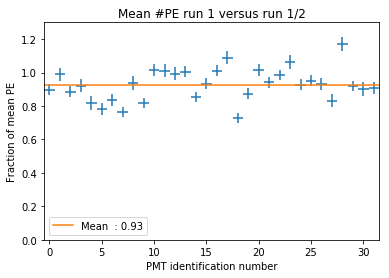

In [22]:
mean_1 = np.mean(flashPE[2],axis=1)
mean_34 = np.mean(flashPE[4],axis=1)
std34 = np.std(flashPE[4],axis=1)/np.sqrt(np.size(flashPE[4], axis=1))/mean_1
ratio = mean_34/mean_1
plt.errorbar(range(32), ratio, yerr=std34, xerr= 0.5, fmt='none')
plt.axhline(np.mean(ratio), color='C1', label='Mean  : {0:.2f}'.format(np.mean(ratio)))
plt.legend(loc = 'lower left')
plt.xlabel('PMT identification number')
plt.ylabel('Fraction of mean PE')
plt.title('Mean #PE run 1 versus run 1/2')
plt.ylim(0,1.3)
plt.xlim(-0.5,31.5)
plt.savefig(outdir+"pmtperun12.pdf", bbox_inches="tight")

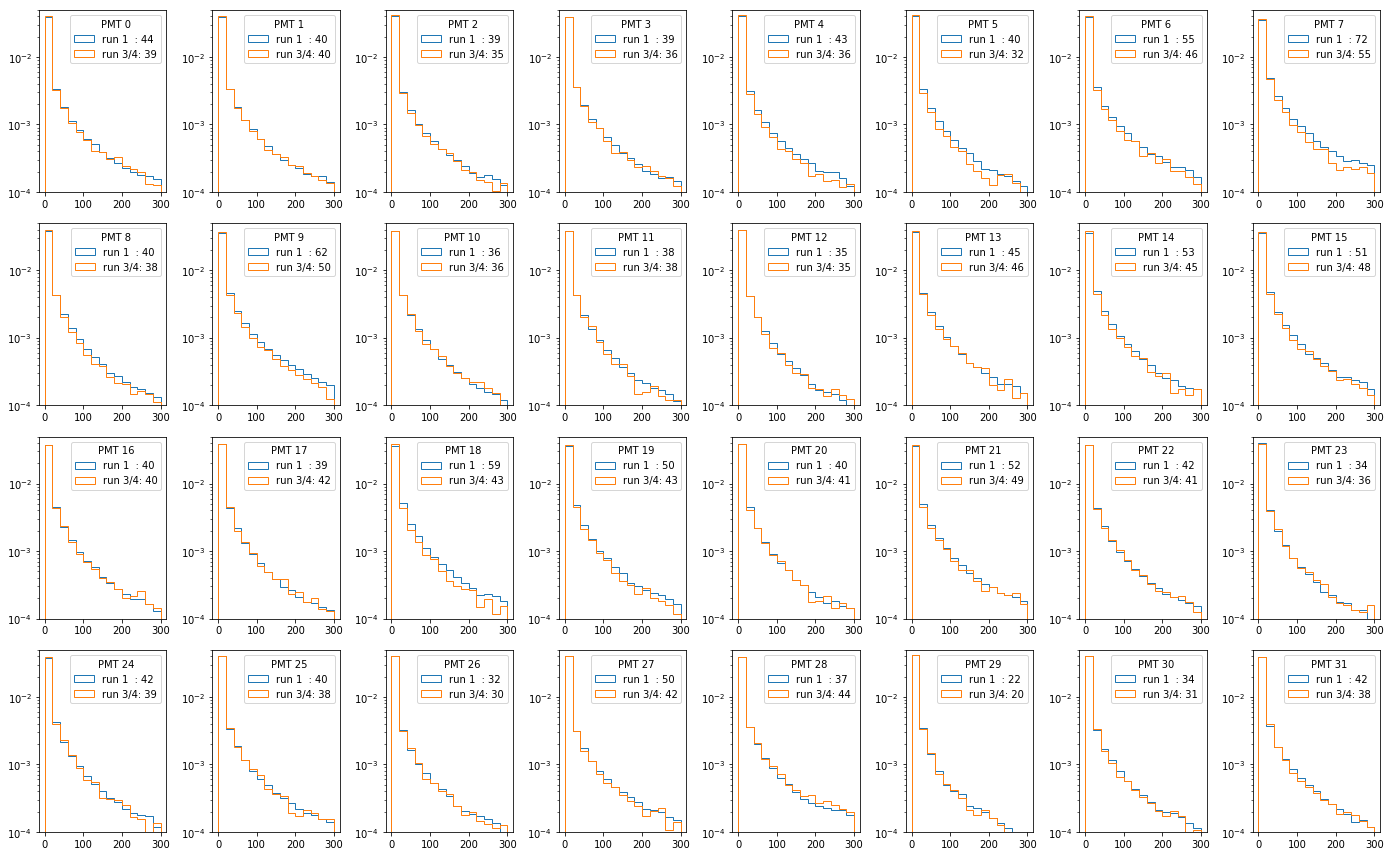

In [23]:
fig,ax = plt.subplots(ncols=8,nrows=4,figsize=(12*gr,12))
ax=ax.flatten()

for i,(pe_1,pe_34) in enumerate(zip(flashPE[2],flashPE[4])):
    ax[i].hist(pe_1, density=1, range=(0,300), label='run 1  : {0:.0f}'.format(np.mean(pe_1)), histtype='step', bins=15)
    ax[i].hist(pe_34, density=1, range=(0,300), label='run 3/4: {0:.0f}'.format(np.mean(pe_34)), histtype='step', bins=15)
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-4,0.05)
    ax[i].legend(title="PMT "+str(i))
fig.tight_layout()
plt.show()

In [24]:
df_nue_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nue']['events']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nue_sig.columns = [c.decode('UTF-8') for c in df_nue_sig.columns ]
df_nue_sig = df_nue_sig.query('leptonEnergy>0.02')
df_nu_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nu']['events']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nu_sig.columns = [c.decode('UTF-8') for c in df_nu_sig.columns ]
df_nu_sig = df_nu_sig.query('leptonEnergy>0.02')

df_nue_sig["hasBeamFlash"].value_counts()
df_nue_sig.head()

,event,foundATargetSlice,hasBeamFlash,leptonEnergy,nFlashes,nFlashesInBeamWindow,nSlices,nSlicesAfterPrecuts,nuCCNC,nuEnergy,nuInteractionTime,nuInteractionType,nuPdgCode,nuVertexX,nuVertexY,nuVertexZ,run,subRun
7,123288,True,True,0.645702,2,1,4,2,0,1.087407,3623.277832,1091,12,84.069183,-33.735760,704.404358,1,6165
13,123294,True,True,1.198930,1,1,5,1,0,1.560767,3603.507812,1000,12,89.114006,-34.161953,893.872742,1,6165
14,123295,True,True,1.106598,1,1,2,1,0,1.347577,3920.541504,1000,12,52.907169,-19.919867,71.344101,1,6165
15,123296,True,True,1.279846,1,1,5,1,0,1.560767,3129.399170,1001,12,89.194656,-34.030945,685.609924,1,6165
16,123297,True,True,0.518815,1,1,5,1,0,1.181747,4213.934570,1004,12,103.555611,-50.605339,35.093502,1,6165


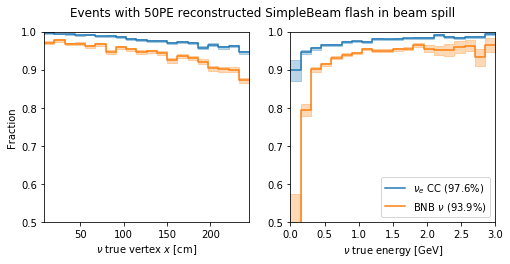

In [25]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle('Events with 50PE reconstructed SimpleBeam flash in beam spill')

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 21
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[0].step(edges, fraq, where='post')
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[0].step(edges, fraq, where='post')
ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlabel(r'$\nu$ true vertex $x$ [cm]')
ax[0].set_xlim(x_min,x_max)

# Right
x_min = 0
x_max = 3
N = 21
edges = np.linspace(x_min,x_max,N)
nom_bins, _ = np.histogram(df_nue_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nue_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
ratio = sum(nom_bins)/sum(denom_bins)
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post', label = r'$\nu_e$ CC ({0:.1f}%)'.format(ratio*100))
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')

nom_bins, _ = np.histogram(df_nu_sig.query('hasBeamFlash')['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_nu_sig['nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
ratio = sum(nom_bins)/sum(denom_bins)
err = np.sqrt( fraq*(1-fraq)/denom_bins )
fraq=np.append(fraq,fraq[-1])
err=np.append(err,err[-1])
ax[1].step(edges, fraq, where='post', label = r'BNB $\nu$ ({0:.1f}%)'.format(ratio*100))
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')

ax[1].legend()
ax[1].set_xlabel(r'$\nu$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min,x_max)

fig.savefig( outdir+"flash_eff_nue.pdf", bbox_inches="tight")

## Slice plots

In [26]:
# Be careful:
# Nue sample is all inside TPC, nu sample is in full cryostat!
# Tag2 MC, loads of events to not have slices!
# We have to correct the POT for this! assume having no slices is independent of anything else:
mask_slices = [file_dict[s]['events'][b'nSlices']>0 for s in dict_names]
scales_nonzeroslices = [s*len(m)/sum(m) for s,m in zip(scales, mask_slices)]

In [27]:
field_arr = [b'nSlices', b'nFlashes', b'nFlashesInBeamWindow', b'foundATargetSlice']
N_arr = [10,4,2,2]
x_min_arr = [-0.5]*4
x_max_arr = [9.5,3.5,1.5,1.5]
apply_mask_arr = [1,0,0,1]
label_arr = ['Number of slices per event', 'Number of flashes per event', 
             'Number of flashes in spill', 'Tagged as neutrino']

arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr, apply_mask_arr]

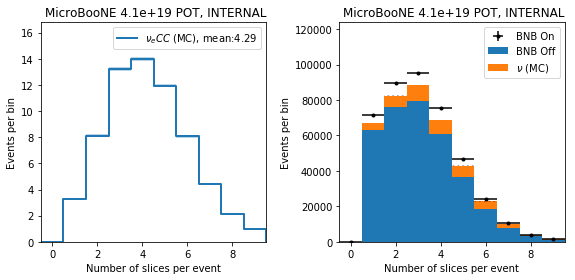

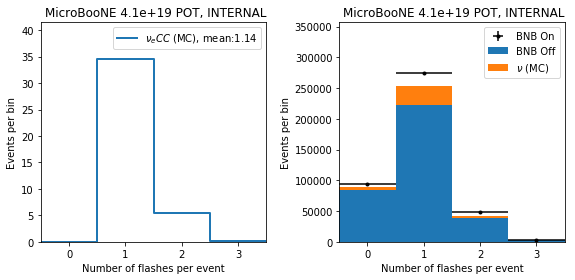

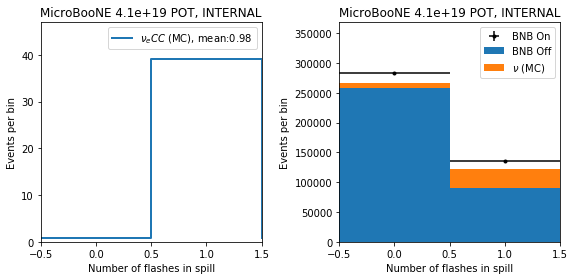

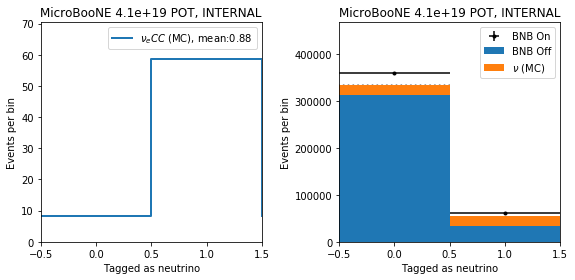

In [28]:
for field, N, x_min, x_max, lab, apply_mask in zip(*arrays):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True)
    if apply_mask:
        data = [file_dict[s]['events'][field][m] for s,m in zip(dict_names, mask_slices)]
        scales_here = scales_nonzeroslices
    else:
        data = [file_dict[s]['events'][field] for s in dict_names]
        scales_here = scales
    # I need a signal sample for nue, overwrite it!    
    data[0] = df_nue_sig.query('nSlices>0')[field.decode('UTF-8')]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])

    # Nue MC
    mean = np.mean(data[0][data[0]>-1])
    bins[0]=np.append(bins[0],bins[0][0])
    err[0]=np.append(err[0],err[0][0])
    ax[0].step(edges,bins[0], lw=2, where='post', label=r'$\nu_e CC$ (MC), mean:{0:0.2f}'.format(mean))
    ax[0].fill_between(edges, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step='post')
    ax[0].set_xlim(x_min,x_max)
    ax[0].set_ylim(0,1.2*max_val[0])
    ax[0].set_xlabel(lab)
    ax[0].set_ylabel('Events per bin')
    ax[0].set_title(title_str, loc='right')
    ax[0].legend()

    # Data/MC
    ax[1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[1].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    y_err = np.sqrt(err[1]**2+err[3])
    val = bins[3]+bins[1]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[1].legend()
    ax[1].set_xlabel(lab)
    ax[1].set_ylabel('Events per bin')
    ax[1].set_title(title_str, loc='right')
    ax[1].set_ylim(0,1.3*max_val[2])

    fig.tight_layout()
    fig.savefig(outdir+field.decode('UTF-8')+".pdf", bbox_inches="tight")

In [29]:
## How many events do have a good slice:
# 80% pure and complete, and collection plane charge!
# First, construct signal frame!
df_nue_slices_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nue']['slices']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nue_slices_sig.columns = [c.decode('UTF-8') for c in df_nue_slices_sig.columns ]
df_nue_slices_sig = df_nue_slices_sig.query('leptonEnergy>0.02')

df_nu_slices_sig = inTPC_df( pd.DataFrame.from_dict(file_dict['nu']['slices']), b'nuVertexX', b'nuVertexY', b'nuVertexZ', fidvol=fidvol_arr)
df_nu_slices_sig.columns = [c.decode('UTF-8') for c in df_nu_slices_sig.columns ]
df_nu_slices_sig = df_nu_slices_sig.query('leptonEnergy>0.02')

query_pure = '(purity>0.8)'
query_complete = '(completeness>0.8)'
query_good = query_pure+' & '+query_complete
query_has_flash = '(isConsideredByFlashId)'
query_good_flash = query_good+' & '+query_has_flash
query_has_deposition = '(hasDeposition)'
query_perfect = query_good_flash+' & '+query_has_deposition

query_perfect_flash_id = query_perfect+' & (isTaggedAsTarget)'
query_perfect_topo_id = query_perfect+' & (hasBestTopologicalScore)'
query_perfect_any_id = query_perfect+' & (hasBestTopologicalScore | isTaggedAsTarget)'
query_perfect_combi_id = query_perfect+'& (CombinedID)'

df_nue_slices_sig.head()

,centerX,centerY,centerZ,chargeToLightRatio,completeness,deltaY,deltaYSigma,deltaZ,deltaZSigma,event,...,nuVertexX,nuVertexY,nuVertexZ,passesPreCuts,purity,run,subRun,topologicalScore,totalCharge,totalPEHypothesis
26,136.798813,1.902606,755.596252,21.676384,0.893855,13.810409,0.310830,21.355164,0.208314,123288,...,84.069183,-33.735760,704.404358,True,0.555556,1,6165,0.006090,108610.281250,5.000838e+03
27,20.950798,20.918158,643.043823,11.647113,0.000000,32.825958,0.738813,-91.197266,-0.889604,123288,...,84.069183,-33.735760,704.404358,True,0.000000,1,6165,0.005443,58358.269531,3.585981e+03
28,85.996346,41.172920,79.658974,12.490843,0.000000,53.080723,1.194686,-654.582092,-6.385268,123288,...,84.069183,-33.735760,704.404358,False,0.000000,1,6165,0.000000,62585.808594,-3.402823e+38
29,78.715584,-79.665375,136.735794,4.886950,0.000000,-67.757568,-1.525017,-597.505310,-5.828499,123288,...,84.069183,-33.735760,704.404358,False,0.000000,1,6165,0.014393,24486.236328,-3.402823e+38
48,105.694084,-38.849072,935.455322,31.402622,0.971975,-25.722179,-0.590947,24.296204,0.286129,123294,...,89.114006,-34.161953,893.872742,True,0.737198,1,6165,0.000000,260474.234375,2.325367e+04


Trying to be smart: Pick the slice that passes precuts and has the highest topological score, if none of these has the highest score, pick flashmatched one!

In [30]:
df_test = df_nue_slices_sig.copy()

grouped = df_test.query('passesPreCuts').groupby(['run', 'subRun', 'event'], sort=False)['hasBestTopologicalScore']
val = grouped.max().values
size = grouped.size().values
val_all = np.repeat(val,size)
mask_passes_precuts = np.where(df_test.eval('passesPreCuts'))[0]
val_all_idx = val_all*mask_passes_precuts
val_all_idx = val_all_idx[val_all_idx != 0]
if (mask_passes_precuts[0]==0) and val_all[0]==True:
    print("BE CAREFUL!")
    val_all_idx = np.insert(val_all_idx,0,0)
final = np.zeros(len(df_test), dtype=bool)
final[val_all_idx] = True
df_test['help_precut_topo'] = final
query_new = '( (help_precut_topo) & (hasBestTopologicalScore) ) | ( (help_precut_topo==False) & (isTaggedAsTarget) ) ' 
df_nue_slices_sig['CombinedID'] = df_test.eval(query_new)

In [32]:
df_nue_slices_sig.query(query_perfect)['CombinedID'].value_counts()/len(df_test.query(query_perfect))*100

True     95.089322
False     4.910678
Name: CombinedID, dtype: float64

In [34]:
max(df_nue_slices_sig.groupby(['run', 'subRun', 'event'])['CombinedID'].sum())
#df_test[['run','subRun','event','passesPreCuts','help_precut_topo','hasBestTopologicalScore']].head(40)

True

End of trying 

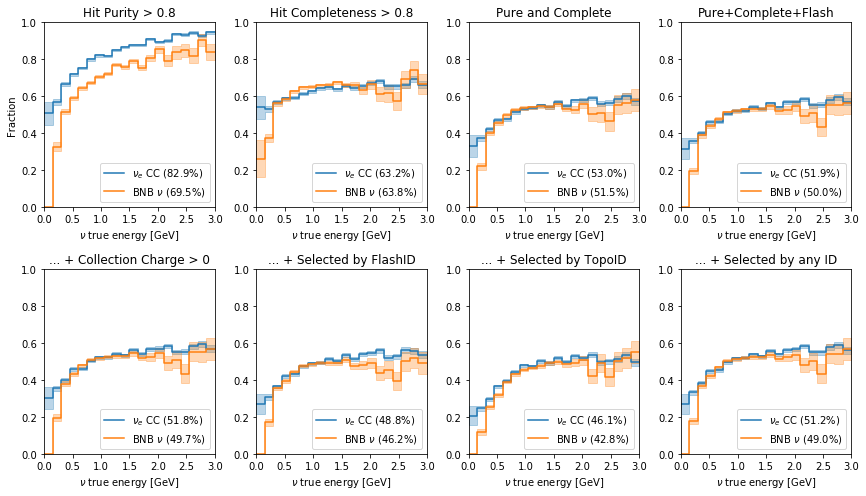

In [35]:
fig,ax=plt.subplots(ncols=4,nrows=2,figsize=(7.5*gr,7))
ax=ax.flatten()
q_arr = [query_pure, query_complete, query_good, query_good_flash, 
         query_perfect, query_perfect_flash_id, query_perfect_topo_id, query_perfect_any_id]
title_arr = ['Hit Purity > 0.8', 'Hit Completeness > 0.8', 'Pure and Complete', 'Pure+Complete+Flash', 
             '... + Collection Charge > 0', '... + Selected by FlashID', '... + Selected by TopoID', '... + Selected by any ID']

x_min = 0
x_max = 3
N = 21
edges = np.linspace(x_min,x_max,N)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
# in the denominator we use the event frames, one entry per event
denom_bins_nue, _ = np.histogram(df_nue_sig.query('nSlices>0')['nuEnergy'], bins=edges)
denom_bins_nu, _ = np.histogram(df_nu_sig.query('nSlices>0')['nuEnergy'], bins=edges)

for i,(query, title) in enumerate(zip(q_arr, title_arr)):
    #nue
    nom_bins, _ = np.histogram(df_nue_slices_sig.query(query)['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nue
    ratio = sum(nom_bins)/sum(denom_bins_nue)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nue)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'$\nu_e$ CC ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C0')
    #nu
    nom_bins, _ = np.histogram(df_nu_slices_sig.query(query)['nuEnergy'], bins=edges)
    fraq = nom_bins/denom_bins_nu
    ratio = sum(nom_bins)/sum(denom_bins_nu)
    err = np.sqrt( fraq*(1-fraq)/denom_bins_nu)
    fraq=np.append(fraq,fraq[-1])
    err=np.append(err,err[-1])
    ax[i].step(edges, fraq, where='post', label = r'BNB $\nu$ ({0:.1f}%)'.format(ratio*100))
    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post', color='C1')
    ax[i].legend(loc='lower right')
    ax[i].set_xlabel(r'$\nu$ true energy [GeV]')
    ax[i].set_title(title)
    ax[i].set_ylim(0.0,1)
    ax[i].set_xlim(x_min,x_max)
    ax[i].set_xticks(np.linspace(0,3,7))
    
ax[0].set_ylabel('Fraction')
fig.tight_layout()
fig.savefig( outdir+"slice_eff_mc.pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


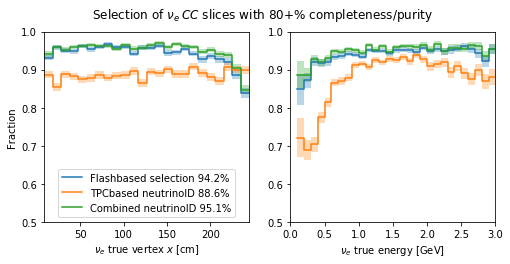

In [36]:
# Make the plot to compare the topological score with the flashbased selection:
x_nue_flash = df_nue_slices_sig.query(query_perfect_flash_id)['nuVertexX']
x_nue_topo = df_nue_slices_sig.query(query_perfect_topo_id)['nuVertexX']
x_nue_combi = df_nue_slices_sig.query(query_perfect_combi_id)['nuVertexX']
x_nue_denom = df_nue_slices_sig.query(query_perfect)['nuVertexX']

E_nue_flash = df_nue_slices_sig.query(query_perfect_flash_id)['nuEnergy']
E_nue_topo = df_nue_slices_sig.query(query_perfect_topo_id)['nuEnergy']
E_nue_combi = df_nue_slices_sig.query(query_perfect_combi_id)['nuEnergy']
E_nue_denom = df_nue_slices_sig.query(query_perfect)['nuEnergy']

ratio_flash = len(df_nue_slices_sig.query(query_perfect_flash_id))/len(df_nue_slices_sig.query(query_perfect))
ratio_topo = len(df_nue_slices_sig.query(query_perfect_topo_id))/len(df_nue_slices_sig.query(query_perfect))
ratio_combi = len(df_nue_slices_sig.query(query_perfect_combi_id))/len(df_nue_slices_sig.query(query_perfect))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,3.5))
fig.suptitle(r'Selection of $\nu_e \: CC$ slices with 80+% completeness/purity')
labels = [
    'Flashbased selection {0:.1f}%'.format(ratio_flash*100),
    'TPCbased neutrinoID {0:.1f}%'.format(ratio_topo*100),
    'Combined neutrinoID {0:.1f}%'.format(ratio_combi*100),
]

# Left
x_min = lower[0]+fidvol_arr[0]
x_max = upper[0]-fidvol_arr[1]
N = 24
data = [x_nue_denom,x_nue_flash,x_nue_topo, x_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[0].step(edges, f, where='post', label = l)
    ax[0].fill_between(edges, f - e, f + e, alpha=0.3, step='post')

ax[0].set_xlabel(r'$\nu_e$ true vertex $x$ [cm]')
ax[0].legend(loc='lower center')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[0].set_xlim(x_min, x_max)

# Right
x_min = 0.0
x_max = 3
N = 30
data = [E_nue_denom,E_nue_flash,E_nue_topo, E_nue_combi]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1:]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= [np.append(f,f[-1]) for f in fraq]
err = [np.append(e,e[-1]) for e in err]

for f,e,l in zip(fraq,err,labels):
    ax[1].step(edges, f, where='post', label = l)
    ax[1].fill_between(edges, f - e, f + e, alpha=0.3, step='post')
    
ax[1].set_xlabel(r'$\nu_e$ true energy [GeV]')
ax[1].set_ylim(0.5,1)
ax[1].set_xticks(np.linspace(x_min,x_max,7))
ax[1].set_xlim(x_min, x_max)

fig.savefig( outdir+"ID_nue.pdf", bbox_inches="tight")

## Plots

In [37]:
# Plots 
plot_fields = ['deltaZ', 'deltaZSigma', 'deltaY', 'deltaYSigma', 'chargeToLightRatio']
plot_x_axis = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$"]

x_min_arr =  [-200,-1.8,-120,-4.0]
x_max_arr =  [150,1.4,120,4.0]
bins_arr = [50,50,50,50]
y_max_arr = [0.033,4.0,0.013,0.55]
y_max_2_arr = [6000,6500,8200,11500]
cut_arr = [105,1.0,95,2.1]

# Define what a bad slice is
query_bad = query_has_flash+' & '+query_has_deposition+' & (purity<0.2) & (completeness<0.2)'
query_bad_flash_id = query_bad+' & (isTaggedAsTarget)'
query_bad_topo_id = query_bad+' & (hasBestTopologicalScore)'

0.9822568911163204
0.9940182685312424
0.9986662355508852
0.9921186646188667


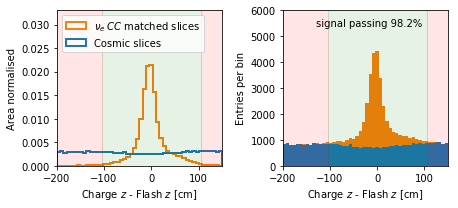

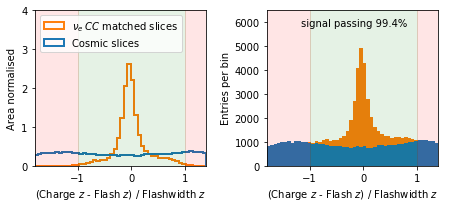

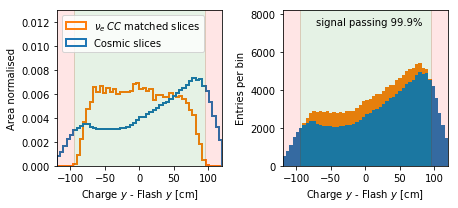

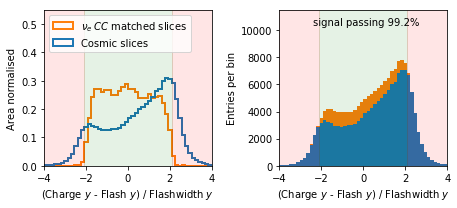

In [38]:
# Plotter
labels = ['Cosmic slices', r'$\nu_e \: CC$ matched slices']

for field,x_axis, x_min, x_max, bins, y_max, y_max2, cut in zip(plot_fields, plot_x_axis, x_min_arr, x_max_arr, bins_arr, y_max_arr, y_max_2_arr ,cut_arr):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3), sharex=True)
    
    data_good = df_nue_slices_sig.query(query_perfect)[field]
    data_bad = df_nue_slices_sig.query(query_bad)[field]
    data = [data_bad,data_good]
    #Ratio of good slices kept by this cut:
    mask_cut = (data_good>-cut) & (data_good<cut)
    ratio_kept = sum(mask_cut)/len(mask_cut) 
    print(ratio_kept)
    
    edges = np.linspace(x_min,x_max, bins+1)
    ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, density=1)
    ax[1].hist(data, bins=edges, label=labels, histtype='barstacked')
    ax[0].set_xlabel(x_axis)
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('Entries per bin')
    ax[0].set_ylabel('Area normalised')
    ax[0].legend(loc='upper left')
    ax[0].set_ylim(0,y_max)
    ax[1].set_ylim(0,y_max2)
    ax[0].set_xlim(x_min,x_max)
    ax[0].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[0].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[0].axvspan(cut,x_max, alpha=0.1, color="red")
    ax[1].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[1].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[1].axvspan(cut,x_max, alpha=0.1, color="red")
    
    text_x = x_min+(x_max-x_min)*0.2
    ax[1].text(text_x, y_max2*0.9, 'signal passing {0:.1f}%'.format(ratio_kept*100))
    
    fig.tight_layout()
    fig.savefig( outdir+field+".pdf")

0.9897744725567861


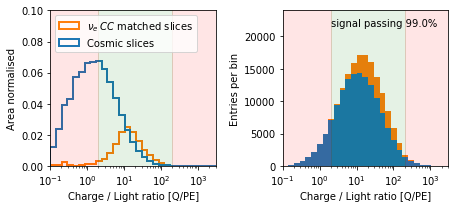

In [39]:
# make charge light ratio plot!
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3), sharex=True)


x_min = 0.1
x_max = 3000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
y_max = 0.1
y_max2= 24000

x_axis = r"Charge / Light ratio [Q/PE]"
field = 'chargeToLightRatio'

data_good = df_nue_slices_sig.query(query_perfect)[field]
data_bad = df_nue_slices_sig.query(query_bad)[field]
data = [data_bad,data_good]
#Ratio of good slices kept by this cut:
mask_cut = (data_good>2) & (data_good<200)
ratio_kept = sum(mask_cut)/len(mask_cut) 
print(ratio_kept)
    

ax[0].hist(data, bins=edges, label=labels, histtype='step', lw=2, density=1)
ax[1].hist(data, bins=edges, label=labels, histtype='barstacked')

ax[0].set_xlabel(x_axis)
ax[1].set_xlabel(x_axis)
ax[1].set_ylabel('Entries per bin')
ax[0].set_ylabel('Area normalised')
ax[0].legend(loc='upper left')
ax[0].set_ylim(0,y_max)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(x_min,x_max)
ax[0].axvspan(x_min,2, alpha=0.1, color="red")
ax[0].axvspan(2,200, alpha=0.1, color="green")
ax[0].axvspan(200,x_max, alpha=0.1, color="red")
ax[1].axvspan(x_min,2, alpha=0.1, color="red")
ax[1].axvspan(2,200, alpha=0.1, color="green")
ax[1].axvspan(200,x_max, alpha=0.1, color="red")
ax[1].set_xscale("log", nonposx='clip') 
ax[0].set_xscale("log", nonposx='clip') 

text_x = 2
ax[1].text(text_x, y_max2*0.9, 'signal passing {0:.1f}%'.format(ratio_kept*100))

fig.tight_layout()
fig.savefig( outdir+field+".pdf")

In [40]:
# How much of the perfect slices is passing the precuts?
df_nue_perfect_slices = df_nue_slices_sig.query(query_perfect).copy()
df_nue_perfect_slices['passesPreCuts'].value_counts()/len(df_nue_perfect_slices)*100

True     96.439253
False     3.560747
Name: passesPreCuts, dtype: float64

In [41]:
# Percent of events in BNB off that passes the selection:
sum(file_dict['off']['events'][b'foundATargetSlice'])/len(file_dict['off']['events'][b'foundATargetSlice'])*100

9.878954719349027

## Make some slice level Data/MC plots

In [42]:
field_arr = [b'totalCharge', b'centerX', b'centerY', b'centerZ']
N_arr = [50,50,50,50]
x_min_arr = [0,*lower]
x_max_arr = [100000,*upper]
label_arr = ['Total charge per slice', 'Charge position of slice $x$ [cm]', 
             'Charge position of slice $y$ [cm]', 'Charge position of slice $z$ [cm]']
arrays = [field_arr, N_arr, x_min_arr, x_max_arr, label_arr]

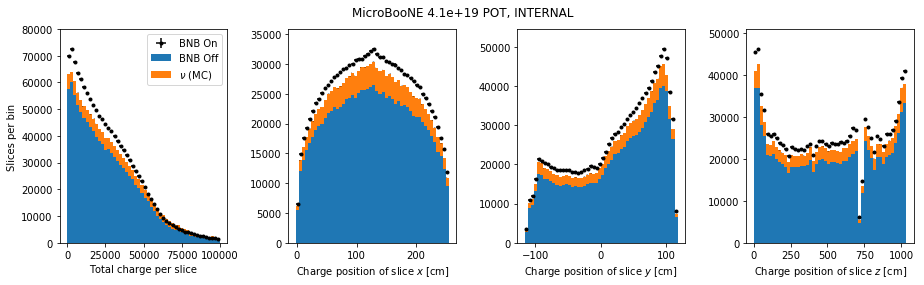

In [43]:
# hits and charge per slice
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(8*gr,4))
fig.suptitle(title_str)

for i,(field, N, x_min, x_max, lab) in enumerate(zip(*arrays)):
    data = [file_dict[s]['slices'][field] for s in dict_names]
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_nonzeroslices)
    widths = (edges_mid - edges[:-1])

    # Data/MC
    ax[i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On")
    ax[i].bar(edges_mid, bins[3], lw=2, label='BNB Off', width = 2*widths)
    ax[i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ (MC)', width = 2*widths, bottom = bins[3])
    y_err = np.sqrt(err[1]**2+err[3])
    val = bins[3]+bins[1]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))

    ax[i].set_xlabel(lab)
    ax[i].set_ylim(0,1.1*max_val[2])

ax[0].legend()
ax[0].set_ylabel('Slices per bin')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig( outdir+"data_mc_slices_charge.pdf", bbox_inches="tight")